## Business Understanding

 **The questions of interest for the Starbucks dataset are as follows:**

* Which demographic groups respond best to which offer type?
* Which demographic groups will make purchases even if they don't receive an offer?
* Who spends the most amount(within each demographics)?
* Build a machine learning model that predicts how much someone will spend based on demographics and offer type.
* Build a model that predicts whether or not someone will respond to an offer.



## Exploratory Data Analysis

In [1]:
def box_plot(data, feature):
    data.boxplot(column=feature)
    plt.xlabel(feature)
    plt.ylabel('label')
    plt.title(feature)
    plt.show()

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('../data/dataset/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/dataset/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/dataset/transcript.json', orient='records', lines=True)

### Analysing dataset 'portfolio'

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# Check shape
portfolio.shape

(10, 6)

In [5]:
# Check for null values
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

#### Analyse distribution of features

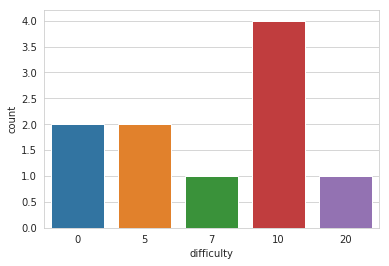

In [6]:
# Column 'difficulty'

sns.set_style('whitegrid')
sns.countplot(x='difficulty', data=portfolio)

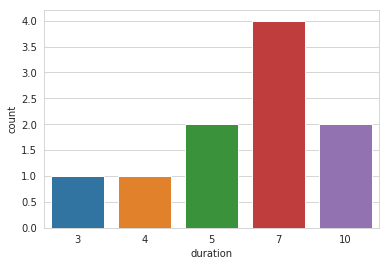

In [7]:
# Column 'duration'

sns.set_style('whitegrid')
sns.countplot(x='duration', data=portfolio)

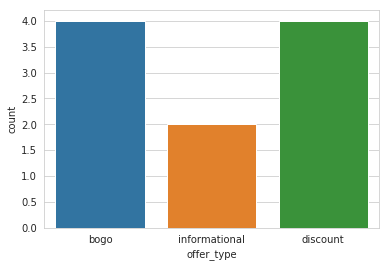

In [8]:
# Column 'offer_type'

sns.set_style('whitegrid')
sns.countplot(x='offer_type', data=portfolio)

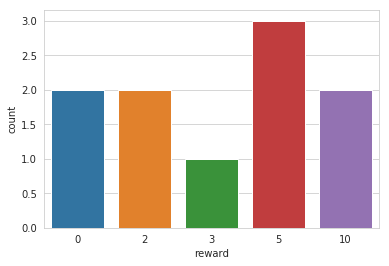

In [9]:
# Column 'reward'

sns.set_style('whitegrid')
sns.countplot(x='reward', data=portfolio)

#### Analyse anomalies

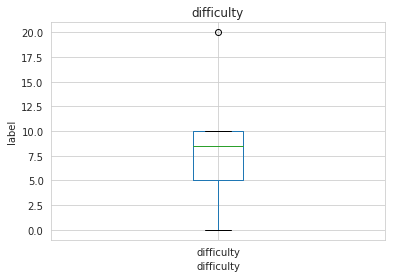

In [10]:
# Column 'difficulty'
box_plot(portfolio, 'difficulty')

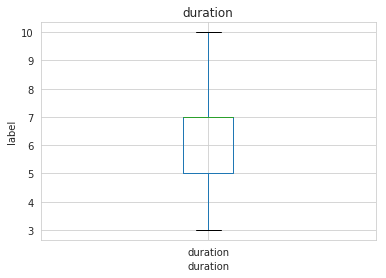

In [11]:
# Column 'duration'
box_plot(portfolio, 'duration')

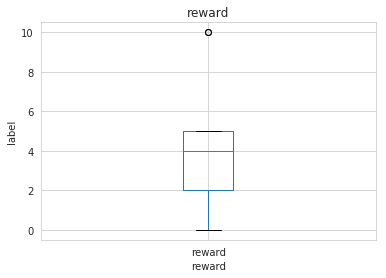

In [12]:
# Column 'reward'
box_plot(portfolio, 'reward')

In [13]:
# Unique offers
list(portfolio['offer_type'].unique())

[u'bogo', u'informational', u'discount']

In [14]:
# Min, Max and Median
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [15]:
# Top offer type
portfolio['offer_type'].describe()

count       10
unique       3
top       bogo
freq         4
Name: offer_type, dtype: object

In [16]:
# Cleaning Channels

def channel_1(x):
    
    try:
        value = x[0]
        
        return value
    
    except:
       
        return float("NAN") 
    
    
def channel_2(x):
    
    try:
        value = x[1]
        
        return value
    
    except:
       
        return float("NAN")
        
def channel_3(x):
    
    try:
        value = x[2]
        
        return value
    
    except:
       
        return float("NAN") 
    
    
def channel_4(x):
    
    try:
        value = x[3]
        
        return value
    
    except:
       
        return float("NAN")     
    

portfolio['channel_1'] = portfolio['channels'].apply(channel_1)
portfolio['channel_2'] = portfolio['channels'].apply(channel_2)
portfolio['channel_3'] = portfolio['channels'].apply(channel_3)
portfolio['channel_4'] = portfolio['channels'].apply(channel_4)

In [17]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,channel_1,channel_2,channel_3,channel_4
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,email,mobile,social,NaN
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,web,email,mobile,social
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,web,email,mobile,NaN
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,web,email,NaN,NaN
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,web,email,mobile,social
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,web,email,mobile,social
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,email,mobile,social,NaN
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,web,email,mobile,social
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,web,email,mobile,NaN


### Analysing dataset 'profile'

In [18]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
# Check shape
profile.shape

(17000, 5)

In [20]:
# Check for null values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

#### Analyse distribution of features

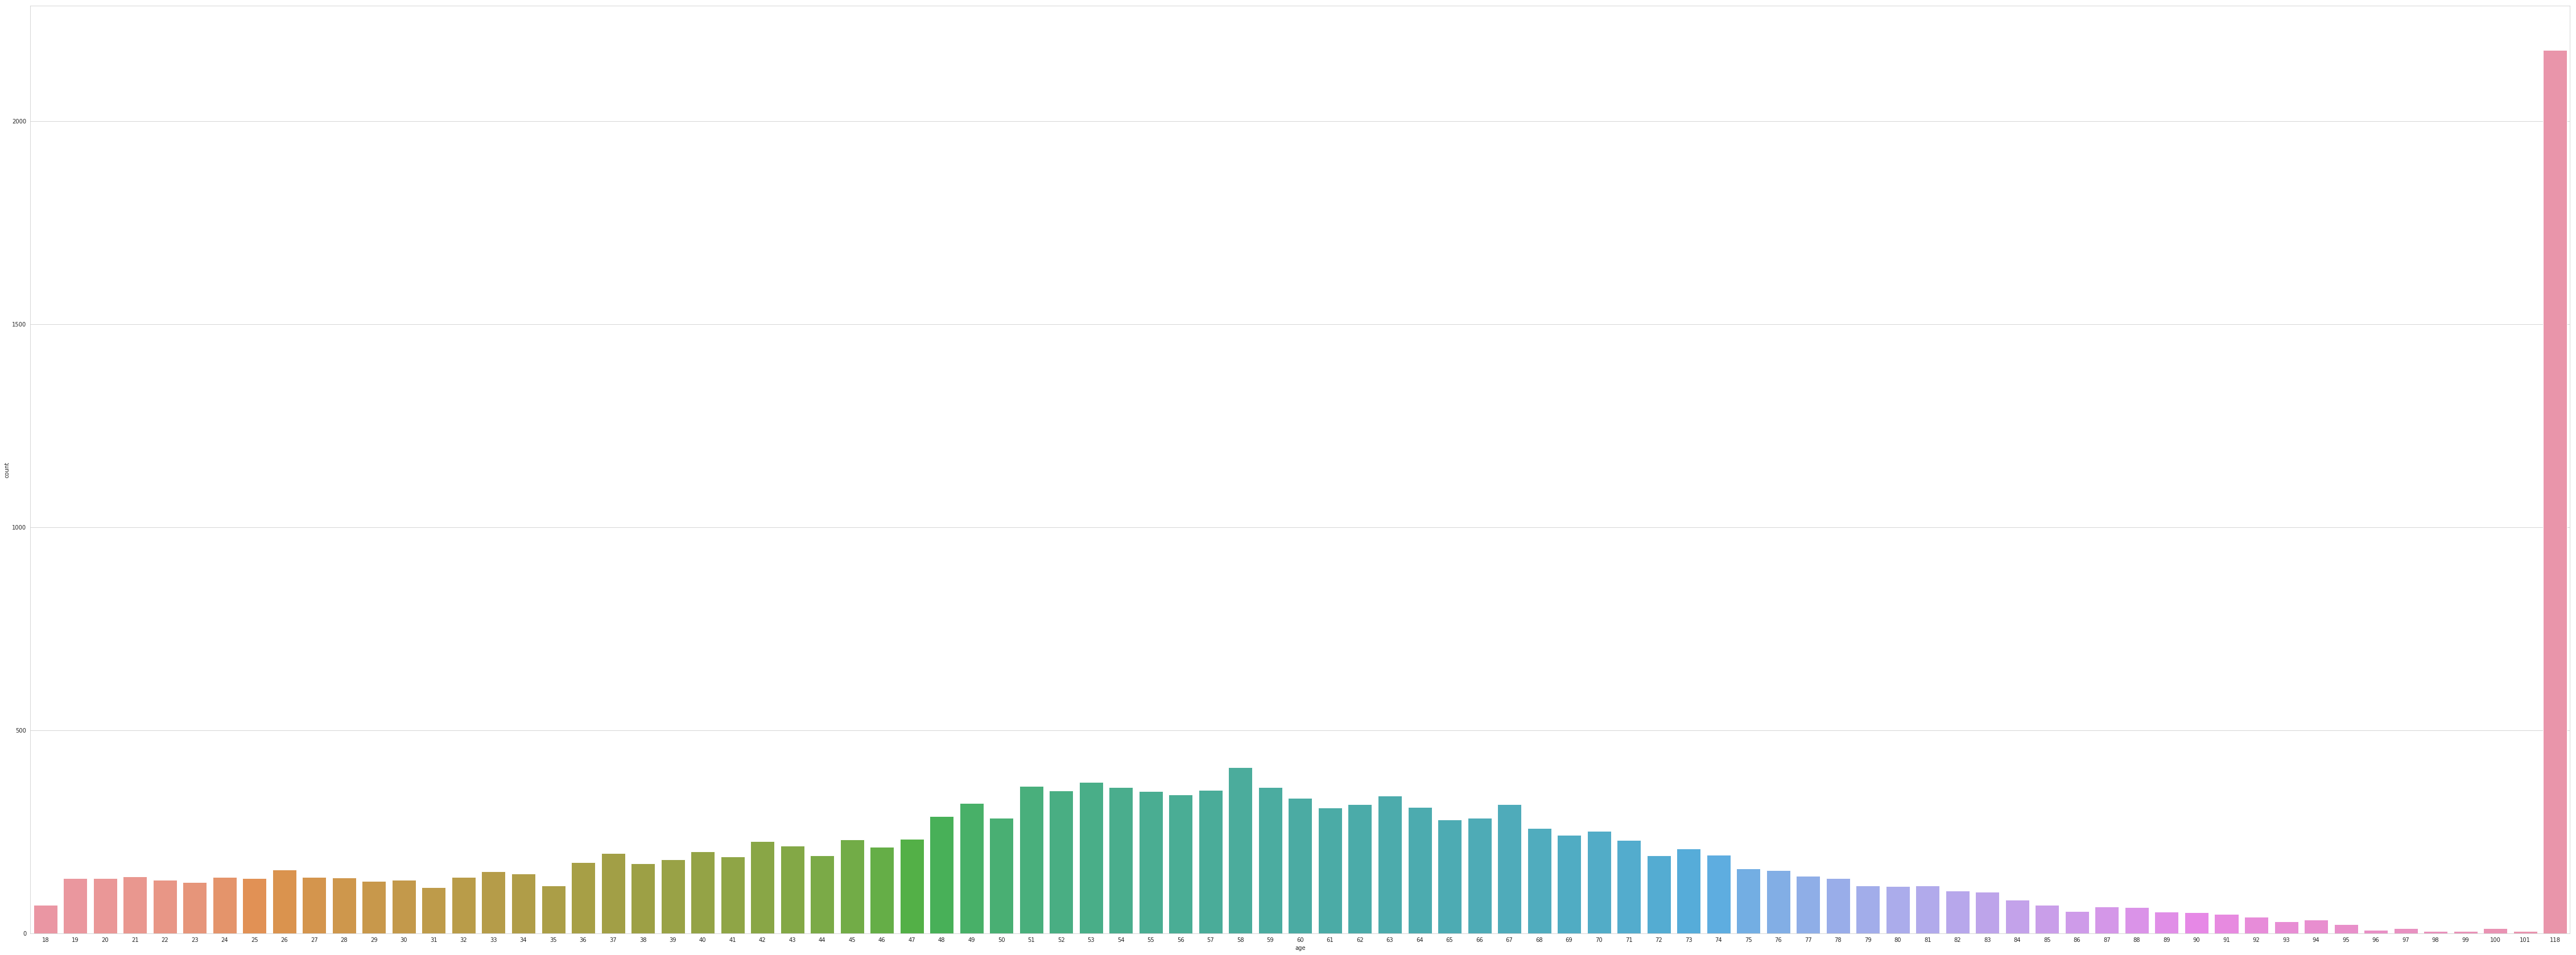

In [21]:
# Column 'age'

dims = (80, 30)
fig, ax = plt.subplots(figsize=dims)

sns.set_style('whitegrid')
sns.countplot(ax=ax, x='age', data=profile)

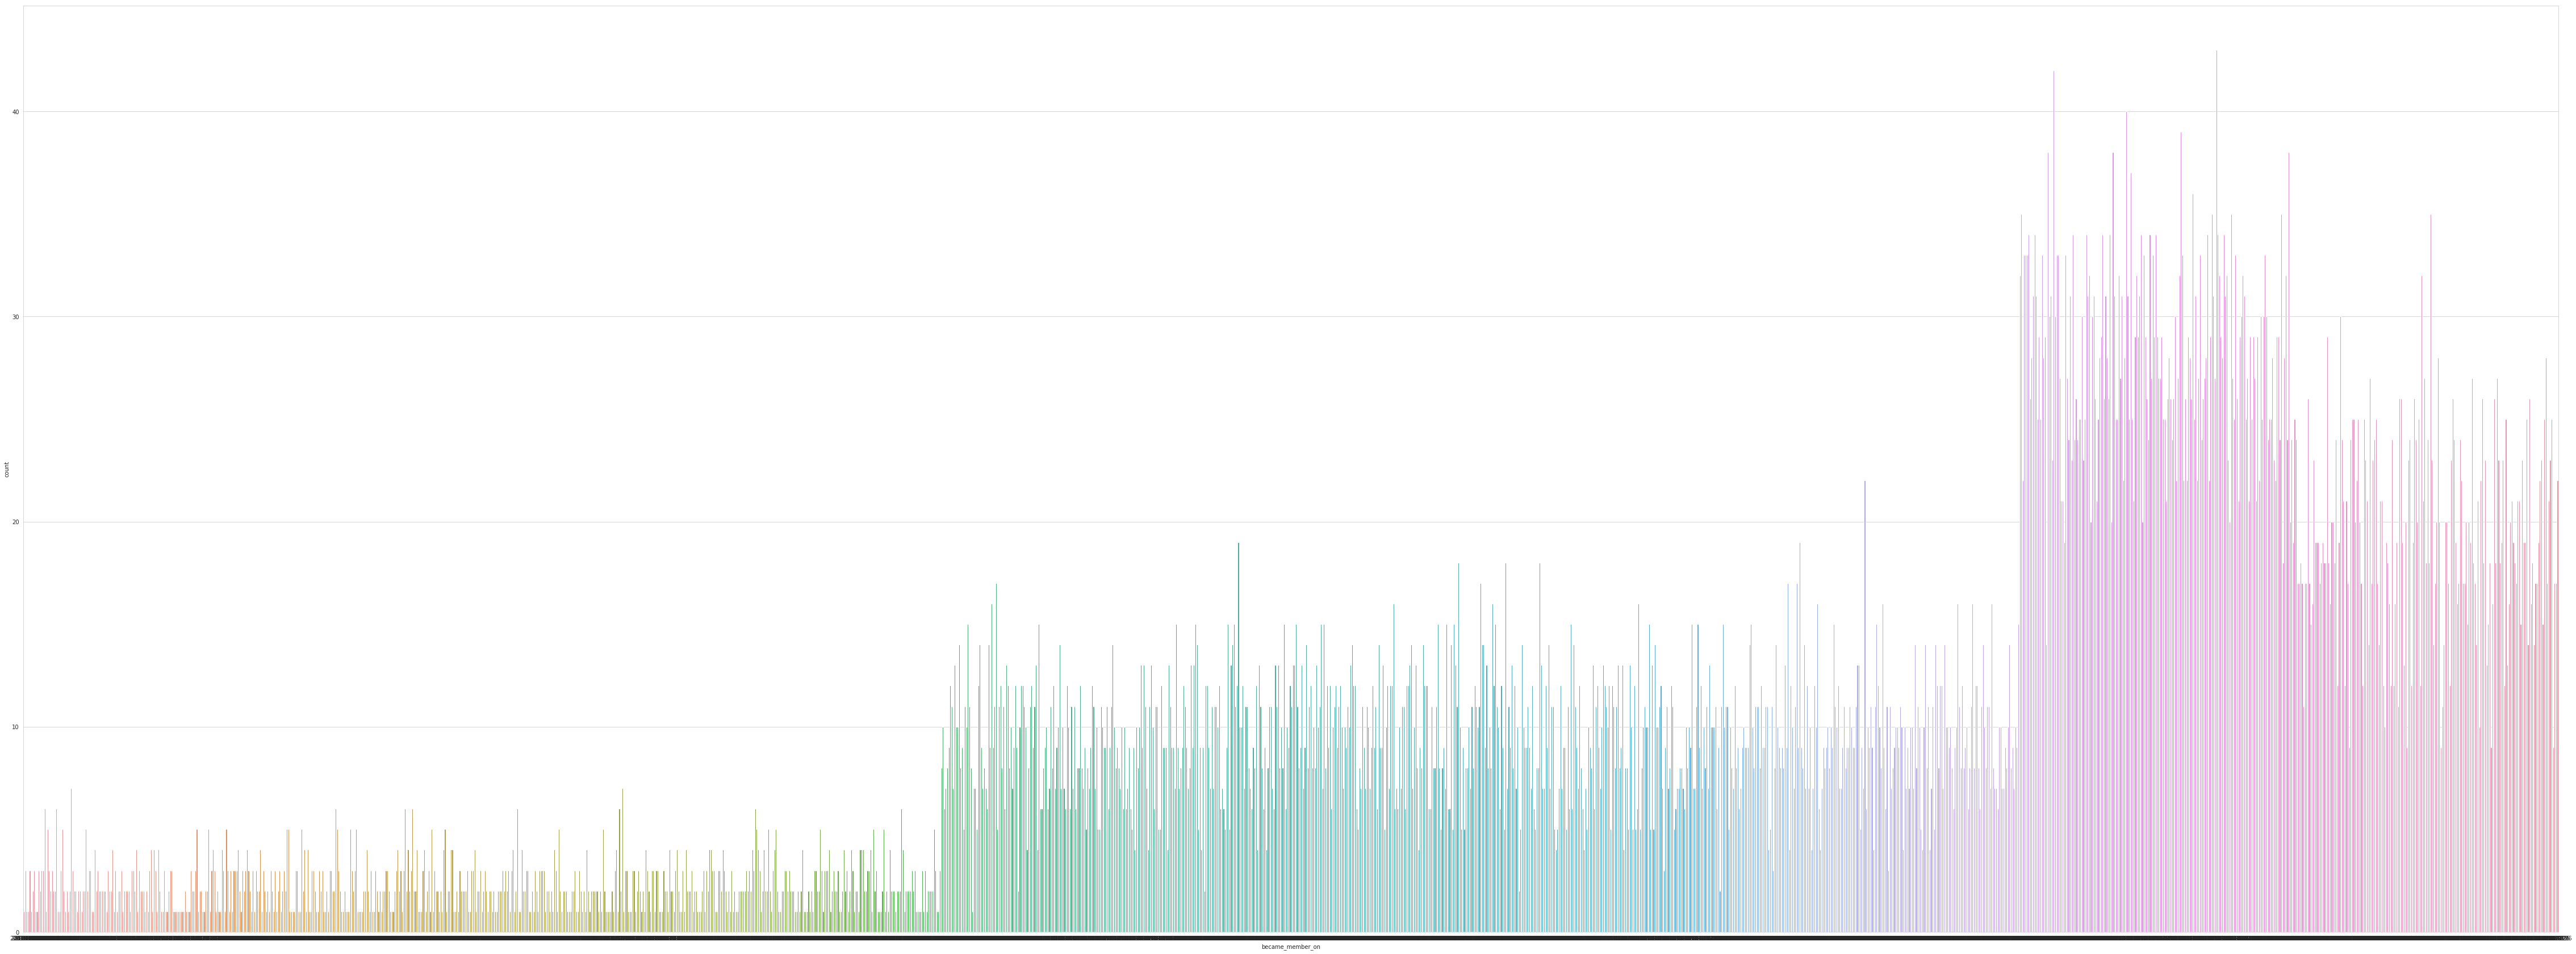

In [22]:
# Column 'became_member_on'

dims = (80, 30)
fig, ax = plt.subplots(figsize=dims)

sns.set_style('whitegrid')
sns.countplot(ax=ax, x='became_member_on', data=profile)

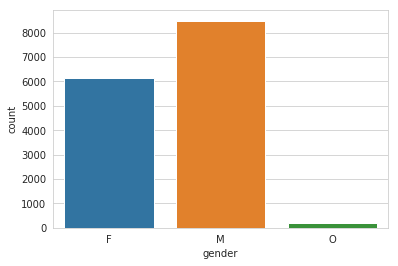

In [23]:
# Column 'gender'

sns.set_style('whitegrid')
sns.countplot(x='gender', data=profile)

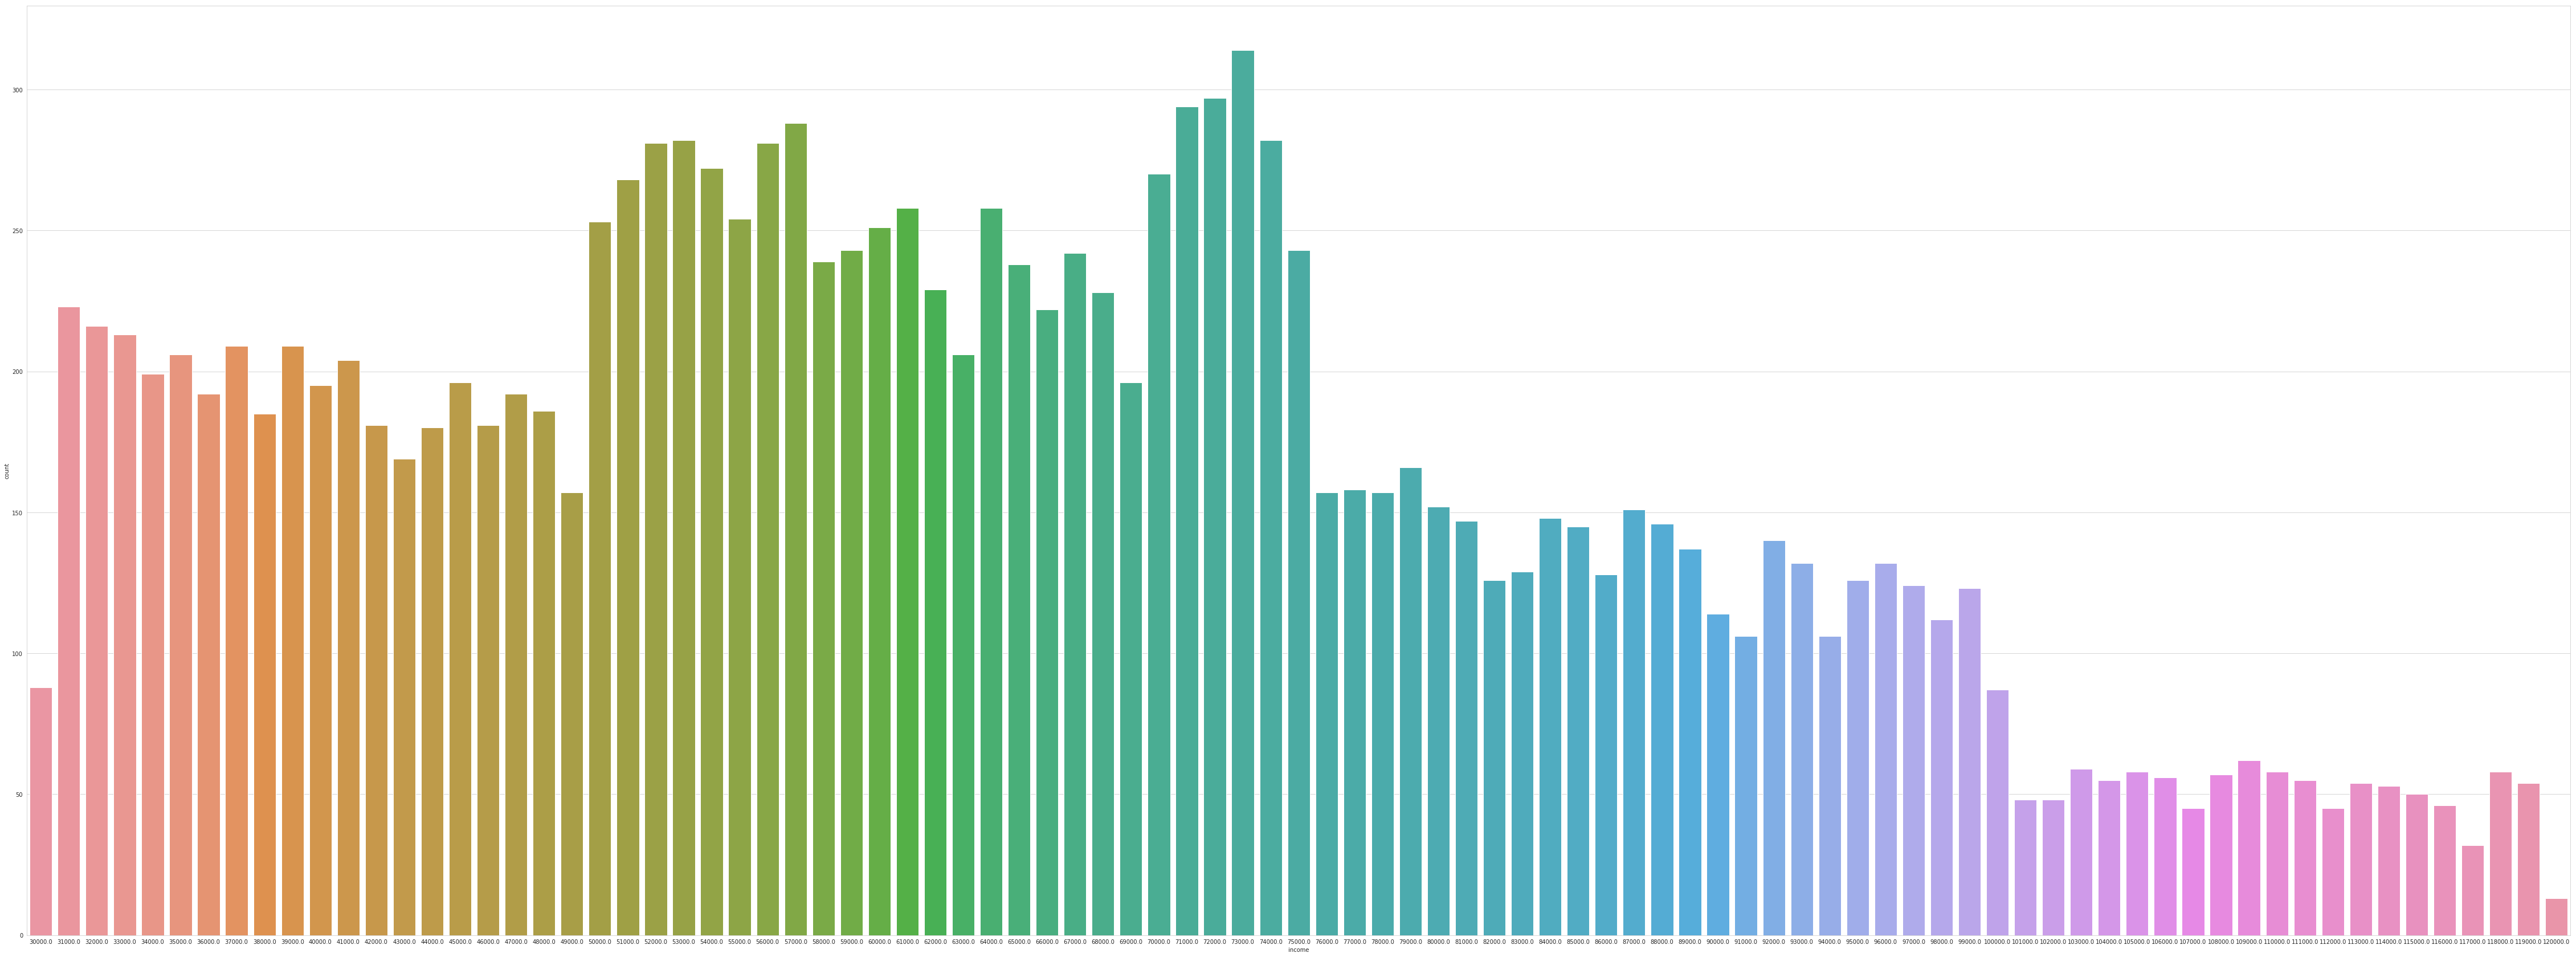

In [24]:
# Column 'income'

dims = (80, 30)
fig, ax = plt.subplots(figsize=dims)

sns.set_style('whitegrid')
sns.countplot(ax=ax, x='income', data=profile)

#### Analyse anomalies

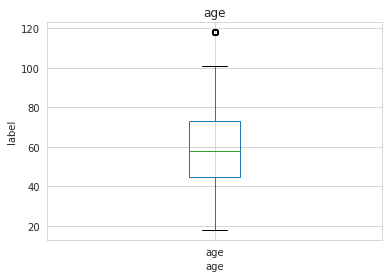

In [25]:
# Column 'age'
box_plot(profile, 'age')

#### There is an anomaly in the column 'age', i.e the age '118'

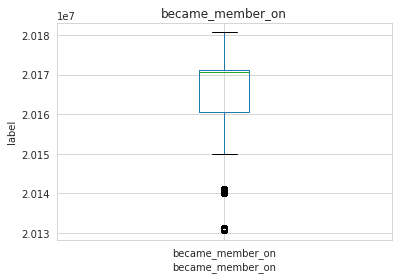

In [26]:
# Column 'became_member_on'
box_plot(profile, 'became_member_on')

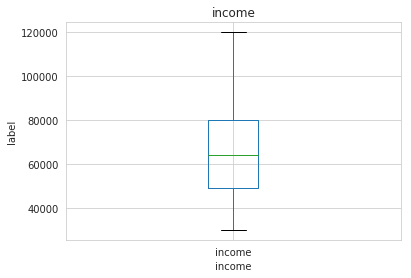

In [27]:
# Column 'income'
box_plot(profile, 'income')

In [28]:
# Min, Max and Median
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [29]:
# Top gender
profile['gender'].describe()

count     14825
unique        3
top           M
freq       8484
Name: gender, dtype: object

In [30]:
# Unique id
len(list(profile['id'].unique()))

17000

In [31]:
# Unique gender
list(profile['gender'].unique())

[None, u'F', u'M', u'O']

### Analysing dataset 'transcript'

In [32]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


In [33]:
# Check shape
transcript.shape

(306534, 4)

In [34]:
# Check for null values
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

#### Analyse distribution of features

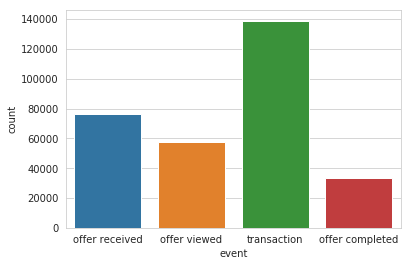

In [35]:
# Column 'event'

sns.set_style('whitegrid')
sns.countplot(x='event', data=transcript)

In [36]:
# Min, Max and Median
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [37]:
# Top event
transcript['event'].describe()

count          306534
unique              4
top       transaction
freq           138953
Name: event, dtype: object

In [38]:
# Unique event
list(transcript['event'].unique())

[u'offer received', u'offer viewed', u'transaction', u'offer completed']

In [39]:
# Unique person
len(list(transcript['person'].unique()))

17000

In [40]:
# Cleaning value
def offer(x):
    try:
       
        value =  x['offer id']
        
        return value
        
    except:
        
        try: 
            
            value =  x['offer_id']
        
            return value
        
        except:
            
            return float("NAN")
  
    
def amount(x):
    try:
       
        value =  x['amount']
        
        return value
        
    except:
        
        return float("NAN")     


In [41]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


## Data Understanding

Now we have the question, we need to move the question into the data. Find the columns from the datasets that would answer these questions.

**The columns identified to answer the necessary questions are as below:**


* Which demographic groups respond best to which offer type?
 -  age, gender, became_member_on, income, offer type
 
* Which demographic groups will make purchases even if they don't receive an offer?
 -  age, offer id, gender, became_member_on, income, amount, person  

* Who spends the most amount(within each demographics)?
 -  age, offer id, gender, became_member_on, income, amount, person  
 
* Build a machine learning model that predicts how much someone will spend based on demographics and offer type.
 - difficulty, duration, reward, age, income, amount, year, month, offer_type, gender 
 
* Build a model that predicts whether or not someone will respond to an offer.
 - reward, age, income, year, month, offer_type, gender 
 


## Data Preparation

In [42]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,channel_1,channel_2,channel_3,channel_4
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,email,mobile,social,NaN
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,web,email,mobile,social
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,web,email,mobile,NaN
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,web,email,NaN,NaN


In [43]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [44]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


In [45]:
def clean_data(profile, portfolio, transcript, offer, amount):
    """
    Function to clean the data

    INPUT:
    profile - (pandas dataframe) profile as defined at the top of the notebook
    portfolio - (pandas dataframe) portfolio as defined at the top of the notebook
    transcript - (pandas dataframe) transcript as defined at the top of the notebook

    OUTPUT:
    offer_type_df - merged dataframe containing columns offer id, offer type, age,
                    became_member_on, gender, person, income
    amount_df - merged dataframe containing columns event, amount, age,
                became_member_on, gender, person, income

    """
    
    # Converting None to NAN
    transcript['offer id'] = transcript['value'].apply(offer)
    transcript['amount'] = transcript['value'].apply(amount)
    
    # Rename column 'id' to 'person'
    profile = profile.rename(columns={'id': 'person'})
    
    # Rename column 'id' to 'offer id'
    portfolio = portfolio.rename(columns={'id': 'offer id'})
    
    # Merge dataframes proflie and transcript
    merged_df = profile.merge(transcript, how='right', on='person')
    
    # Drop Nan values in column 'Gender', 'Income'
    merged_df = merged_df.dropna(subset=['income'])
    
    # Drop column 'value'
    merged_df.drop(columns=['value'], inplace=True)
    
    # Create offer dataframe - offer_df
    offer_df = merged_df.dropna(subset=['offer id'])
    
    # Drop column 'amount' from offer_df dataframe
    offer_df.drop(columns=['amount'], inplace=True)
    
    # Merge dataframes portfolio and offer_df, map columns 'offer id' to 'offer type'
    offer_type_df = portfolio.merge(offer_df, how='right', on='offer id')
    
    # Create amount dataframe - amount_df
    amount_df = merged_df.dropna(subset=['amount'])
    
    # Drop column 'offer id'
    amount_df.drop(columns=['offer id'], inplace=True)
    
    return offer_type_df, amount_df
    
    
offer_type_df, amount_df = clean_data(profile, portfolio, transcript, offer, amount)    

/home/jyothish/.local/lib/python2.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Statistical Analysis

* Which demographic groups respond best to which offer type?

In [46]:
# Demographic groups and offer
#-----------------------------

In [47]:
offer_type_df.sort_values(by=['person','time'])

,channels,difficulty,duration,offer id,offer_type,reward,channel_1,channel_2,channel_3,channel_4,age,became_member_on,gender,person,income,event,time
107900,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,email,mobile,social,NaN,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer received,168
107901,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,email,mobile,social,NaN,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer viewed,192
34647,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer received,336
34648,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer viewed,372
121537,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,web,email,mobile,social,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer received,408
121538,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,web,email,mobile,social,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer completed,414
121539,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,web,email,mobile,social,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer viewed,456
91408,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,web,email,mobile,social,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer received,504
91409,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,web,email,mobile,social,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer completed,528
91410,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,web,email,mobile,social,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,offer viewed,540


In [48]:
offer_type_df[offer_type_df['offer_type'] == 'informational']

,channels,difficulty,duration,offer id,offer_type,reward,channel_1,channel_2,channel_3,channel_4,age,became_member_on,gender,person,income,event,time
32473,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,504
32474,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,offer received,336
32475,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,offer received,0
32476,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,offer received,576
32477,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,64,20170909,M,4b0da7e80e5945209a1fdddfe813dbe0,100000.0,offer received,408
32478,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,64,20170909,M,4b0da7e80e5945209a1fdddfe813dbe0,100000.0,offer viewed,468
32479,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,78,20170616,F,c27e0d6ab72c455a8bb66d980963de60,71000.0,offer received,0
32480,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,78,20170616,F,c27e0d6ab72c455a8bb66d980963de60,71000.0,offer viewed,18
32481,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,78,20170616,F,c27e0d6ab72c455a8bb66d980963de60,71000.0,offer received,336
32482,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,78,20170616,F,c27e0d6ab72c455a8bb66d980963de60,71000.0,offer viewed,348


In [49]:
def offer_viewed_completed(offer_type_df):
    """
    Function to generate features for training the model

    INPUT:
    offer_type_df - (pandas dataframe) offer_type_df returned by function clean_data
    
    OUTPUT:
    merged_offer - (pandas dataframe) merged_offer contains rows with demographics who 
                    has viewed and completed offers, sorted by column 'time' 

    """
    # Filter by offer viewed
    offer_type_viewed_df = offer_type_df[offer_type_df['event'] == 'offer viewed'] 

    # Filter by offer completed
    offer_type_completed_df = offer_type_df[offer_type_df['event'] == 'offer completed'] 

    # Select obly columns 'person' and 'offer id' from the dataframe offer_type_completed_df
    offer_type_completed_df = offer_type_completed_df[['person','offer id']]

    # Merge dataframes offer_type_viewed_df and offer_type_completed_df
    merged_offer = offer_type_viewed_df.merge(offer_type_completed_df, how='inner', on=['person','offer id'])

    # Sort datarame by column 'time'
    merged_offer = merged_offer.sort_values(by=['time'])
    
    return merged_offer

merged_offer = offer_viewed_completed(offer_type_df)

In [50]:
# Filter by gender as 'M' and age as '35'

df_gender_age_M_35 = merged_offer[(merged_offer['gender'] == 'M') & (offer_type_df['age'] == 35)]
df_gender_age_M_35['offer_type'].value_counts(normalize=True) * 100

/home/jyothish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


discount    62.209302
bogo        37.790698
Name: offer_type, dtype: float64

#### 62.2 % of Men who were 35 years old responded to discount offer type 

In [51]:
# Filter by gender as 'F' and age as '35'

df_gender_age_F_35 = merged_offer[(merged_offer['gender'] == 'F') & (offer_type_df['age'] == 35)]  
df_gender_age_F_35['offer_type'].value_counts(normalize=True) * 100

/home/jyothish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


bogo        59.398496
discount    40.601504
Name: offer_type, dtype: float64

##### 59.3 % of Women who were 35 years old responded to discount offer type 

In [52]:
# Filter by gender as 'F' and age as '18'

df_gender_age_F_18 = merged_offer[(merged_offer['gender'] == 'F') & (offer_type_df['age'] == 18)]  
df_gender_age_F_18['offer_type'].value_counts(normalize=True) * 100

/home/jyothish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


discount    63.855422
bogo        36.144578
Name: offer_type, dtype: float64

##### 63.8 % of Women who were 18 years old responded to bogo offer type 

In [53]:
# Filter by gender as 'M' and age as '18'

df_gender_age_M_18 = merged_offer[(merged_offer['gender'] == 'M') & (offer_type_df['age'] == 18)]  
df_gender_age_M_18['offer_type'].value_counts(normalize=True) * 100

/home/jyothish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


bogo        54.411765
discount    45.588235
Name: offer_type, dtype: float64

##### 54.4 % of Men who were 18 years old responded to bogo offer type 

In [54]:
# Filter by gender as 'F' and income in between '60000' and '100000'

df_gender_age_F_income_more = merged_offer[(merged_offer['gender'] == 'F') & (offer_type_df['income'] > 60000.0) & (offer_type_df['income'] < 100000.0)] 
df_gender_age_F_income_more['offer_type'].value_counts(normalize=True) * 100

/home/jyothish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


bogo        50.603822
discount    49.396178
Name: offer_type, dtype: float64

##### 50.6 % of Women who earned income in between 60000 and 100000 responded to bogo offer type 

In [55]:
# Filter by gender as 'F' and income in between '40000' and '60000'

df_gender_age_F_income_less = merged_offer[(merged_offer['gender'] == 'F') & (offer_type_df['income'] > 40000.0) & (offer_type_df['income'] < 60000.0)]
df_gender_age_F_income_less['offer_type'].value_counts(normalize=True) * 100

/home/jyothish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


bogo        51.582749
discount    48.417251
Name: offer_type, dtype: float64

##### 51.5 % of Women who earned income in between 40000 and 60000 responded to bogo offer type 

In [56]:
# Popular offer type among Age group

group_offer_age_df = offer_type_df.groupby(['age'])['offer_type'].describe() 
group_offer_age_df.sort_values(by=['top'])

,count,unique,top,freq
age,,,,
18,668,3,bogo,290
54,3593,3,bogo,1543
55,3628,3,bogo,1556
57,3708,3,bogo,1600
100,126,3,bogo,60
61,3127,3,bogo,1358
62,3260,3,bogo,1414
63,3493,3,bogo,1574
66,2832,3,bogo,1226


In [57]:
# Popular offer type among Gender group

group_offer_gender_df = offer_type_df.groupby(['gender'])['offer_type'].describe()
group_offer_gender_df.sort_values(by=['top'])

,count,unique,top,freq
gender,,,,
F,63719,3,bogo,27619
M,82896,3,bogo,35301
O,2190,3,discount,920


In [58]:
# Popular offer type among Became_member_on group

group_offer_became_member_on_df = offer_type_df.groupby(['became_member_on'])['offer_type'].describe()
group_offer_became_member_on_df.sort_values(by=['top'])

,count,unique,top,freq
became_member_on,,,,
20160325,130,3,bogo,59
20160826,87,3,bogo,37
20160825,109,3,bogo,58
20160823,46,3,bogo,23
20160822,20,3,bogo,9
20160820,80,3,bogo,38
20160818,57,3,bogo,36
20160830,65,3,bogo,34
20160814,93,3,bogo,46


In [59]:
# Popular offer type among Income group

group_offer_income_df = offer_type_df.groupby(['income'])['offer_type'].describe()
group_offer_income_df.sort_values(by=['top'])

,count,unique,top,freq
income,,,,
30000.0,778,3,bogo,354
67000.0,2431,3,bogo,1070
70000.0,2722,3,bogo,1189
71000.0,2998,3,bogo,1304
73000.0,3234,3,bogo,1496
78000.0,1676,3,bogo,736
81000.0,1570,3,bogo,672
83000.0,1366,3,bogo,608
84000.0,1557,3,bogo,718


* Which demographic groups will make purchases even if they don't receive an offer?

In [60]:
def purchase_without_offer(offer_type_df, amount_df):
    """
    Function to find the demographic groups that will make purchases even if they don't receive an offer

    INPUT:
    offer_type_df - (pandas dataframe) offer_type_df returned by function clean_data
    amount_df - (pandas dataframe) amount_df returned by function clean_data

    OUTPUT:
    match_df - (pandas dataframe) dataframe which contains demographic groups that will
                make purchases even if they don't receive an offer

    """
    
    # Filter by offer viewed
    offer_type_viewed_df = offer_type_df[offer_type_df['event'] == 'offer viewed'] 

    # Filter by offer completed
    offer_type_completed_df = offer_type_df[offer_type_df['event'] == 'offer completed'] 

    # Select obly columns 'person' and 'time' from the dataframe offer_type_completed_df
    offer_type_completed_df = offer_type_completed_df[['person','time']]

    # Merge dataframes offer_type_viewed_df and offer_type_completed_df
    merged_offer = offer_type_viewed_df.merge(offer_type_completed_df, how='inner', on=['person','time'])
    
    # List of persons
    person_list = list(merged_offer['person'])
    
    # List of time
    time_list = list(merged_offer['time'])
        
    # Empty dataframe of type amount_df    
    match_df = amount_df[amount_df['age'] == 144]

    for person, time in zip(person_list, time_list) :

        match_df = pd.concat([match_df, amount_df[amount_df['person'].isin([person]) & amount_df['time'].isin([time])]])
    
    
    return match_df


match_df = purchase_without_offer(offer_type_df, amount_df)

In [61]:
match_df.head()

,age,became_member_on,gender,person,income,event,time,amount
339,64,20170909,M,4b0da7e80e5945209a1fdddfe813dbe0,100000.0,transaction,510,31.05
1309,53,20161231,F,3a1242dda16248728e350c4bdeb21972,117000.0,transaction,348,26.65
1419,59,20170820,M,0b73997a269247088b2a63355f53ee58,89000.0,transaction,48,22.96
2325,64,20170421,F,f35b342b24734da18a830bb9329a4fbd,66000.0,transaction,360,13.01
2452,79,20160627,M,81e9ad5fa55a4884b65e01a5db8f1b4e,67000.0,transaction,174,49.09


In [62]:
# Find difference of dataframes

diff_df = amount_df[~amount_df.apply(tuple,1).isin(match_df.apply(tuple,1))]

In [63]:
# The demographic groups that will make purchases even if they don't receive an offer

diff_df.head()

,age,became_member_on,gender,person,income,event,time,amount
21,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,18,21.51
22,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,144,32.28
25,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,528,23.22
39,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,transaction,132,19.89
41,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,transaction,144,17.78


In [64]:
# Age 

diff_df['age'].value_counts(normalize=True) * 100

58     2.675461
54     2.374152
51     2.337830
53     2.318017
57     2.210702
55     2.205749
59     2.145487
52     2.142185
63     2.095131
60     2.091829
67     2.017534
56     1.972956
62     1.944889
61     1.944064
49     1.901963
64     1.900312
48     1.844178
66     1.844178
50     1.775661
65     1.771533
68     1.655137
69     1.592399
45     1.563506
40     1.529660
47     1.510674
43     1.509023
37     1.499117
39     1.490036
70     1.476828
42     1.464446
         ...   
22     1.003814
76     0.998861
75     0.951807
77     0.904753
78     0.850270
31     0.822203
83     0.740478
80     0.703330
81     0.691773
82     0.681867
79     0.670310
18     0.571249
84     0.537404
87     0.450726
85     0.436692
88     0.380558
89     0.338457
86     0.325249
90     0.274893
91     0.269115
92     0.260860
94     0.200598
93     0.197296
95     0.127128
97     0.083376
100    0.083376
96     0.038799
101    0.038799
98     0.037973
99     0.028893
Name: age, Length: 84, d

##### People of age 58 makes the most purchases without an offer

In [65]:
# Gender

diff_df['gender'].value_counts(normalize=True) * 100

M    58.983969
F    39.595338
O     1.420694
Name: gender, dtype: float64

##### Men makes the most purchases without an offer

In [66]:
# Became_member_on 

diff_df['became_member_on'].value_counts(normalize=True) * 100

20171212    0.242698
20171207    0.238571
20180125    0.213806
20171007    0.205551
20171026    0.198947
20170815    0.198947
20171121    0.191517
20170910    0.191517
20170830    0.191517
20180123    0.186564
20170819    0.185739
20171214    0.184088
20180109    0.184088
20170811    0.183262
20171114    0.181611
20170802    0.180786
20171023    0.179960
20170928    0.179135
20171002    0.178309
20171213    0.175833
20170730    0.174182
20170911    0.171705
20170806    0.170054
20170821    0.169228
20171220    0.167577
20171112    0.166752
20171118    0.165926
20170807    0.164275
20171016    0.164275
20171019    0.163450
              ...   
20150206    0.004128
20140727    0.004128
20141112    0.004128
20150609    0.004128
20150515    0.004128
20140918    0.004128
20131129    0.004128
20150706    0.004128
20140212    0.004128
20130731    0.004128
20131202    0.004128
20141205    0.004128
20150602    0.004128
20131019    0.003302
20131222    0.003302
20140209    0.003302
20140228    0

##### People who became member in the year 2017 makes the most purchases without an offer

In [67]:
# Income 

diff_df['income'].value_counts(normalize=True) * 100

73000.0     2.134755
52000.0     2.086876
57000.0     2.072017
53000.0     2.038171
72000.0     2.032393
56000.0     1.995245
54000.0     1.986990
61000.0     1.946540
51000.0     1.927554
50000.0     1.923426
64000.0     1.893708
71000.0     1.873070
55000.0     1.849956
32000.0     1.848305
60000.0     1.844178
31000.0     1.829319
74000.0     1.790520
65000.0     1.769057
70000.0     1.756674
59000.0     1.754198
37000.0     1.738513
33000.0     1.731084
39000.0     1.731084
66000.0     1.730258
35000.0     1.712097
67000.0     1.707144
68000.0     1.684855
58000.0     1.681553
34000.0     1.671647
36000.0     1.647708
              ...   
99000.0     0.652974
95000.0     0.649672
89000.0     0.643894
83000.0     0.643068
97000.0     0.620780
90000.0     0.605921
94000.0     0.578679
98000.0     0.539880
91000.0     0.496128
100000.0    0.402846
103000.0    0.309564
118000.0    0.307913
114000.0    0.290578
105000.0    0.287276
110000.0    0.279846
106000.0    0.275719
109000.0    0

##### People who has an income around 73000.0 makes the most purchases without an offer

* Who spends the most amount(within each demographics)?

In [68]:
amount_age_df = amount_df.groupby(['age'])['amount'].sum().to_frame()

In [69]:
# Top 10 age which spends the most amount

amount_age_df = amount_age_df.sort_values(by=['amount'], ascending=False)

amount_age_df.head(10)

,amount
age,
58,56201.03
53,50985.19
55,49928.62
57,48138.62
59,43947.55
54,43417.10
67,42483.99
51,42257.66
63,41243.36


In [70]:
amount_gender_df = amount_df.groupby(['gender'])['amount'].sum().to_frame()

In [71]:
# Top gender which spends the most amount

amount_gender_df = amount_gender_df.sort_values(by=['amount'], ascending=False)

amount_gender_df.head()

,amount
gender,
F,863695.00
M,844890.86
O,26356.54


In [72]:
amount_became_member_on_df = amount_df.groupby(['became_member_on'])['amount'].sum().to_frame()

In [73]:
# Top 10 became_member_on which spends the most amount

amount_became_member_on_df = amount_became_member_on_df.sort_values(by=['amount'], ascending=False)

amount_became_member_on_df.head(10)

,amount
became_member_on,
20171114,4950.71
20170815,4556.10
20170924,4038.07
20171007,3990.83
20171207,3826.20
20161111,3694.93
20170202,3681.06
20170807,3673.41
20171212,3492.65


In [74]:
amount_income_df = amount_df.groupby(['income'])['amount'].sum().to_frame()

In [75]:
# Top 10 income which spends the most amount

amount_income_df = amount_income_df.sort_values(by=['amount'], ascending=False)

amount_income_df.head(10)

,amount
income,
73000.0,41677.94
72000.0,39436.83
71000.0,37808.33
74000.0,35315.08
70000.0,33107.45
75000.0,32037.00
64000.0,31644.61
67000.0,27831.57
61000.0,27827.53


## Modelling and Evaluation

* Build a machine learning model that predicts how much someone will spend based on demographics and offer type.

In [76]:
# Prepare data for training the model

""" 
Here we are implementing a Linear regression model to predict how much someone will spend based on demographics 
and offer type.

To evaluate the trained model we use the r2 score metric. 

The function generate_features_regression generate the features for training and testing.

"""

' \nHere we are implementing a Linear regression model to predict how much someone will spend based on demographics \nand offer type.\n\nTo evaluate the trained model we use the r2 score metric. \n\nThe function generate_features_regression generate the features for training and testing.\n\n'

In [77]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,channel_1,channel_2,channel_3,channel_4
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,email,mobile,social,NaN
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,web,email,mobile,social
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,web,email,mobile,NaN
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,web,email,NaN,NaN


In [78]:
def generate_features_regression(portfolio, transcript, amount_df):
    """
    Function to generate features for training the model

    INPUT:
    portfolio - (pandas dataframe) portfolio as defined at the top of the notebook
    transcript - (pandas dataframe) transcript as defined at the top of the notebook
    amount_df - (pandas dataframe) amount_df returned by function clean_data

    OUTPUT:
    df_offer_type_amount - (pandas dataframe) dataframe which contains the features 
                           for training the model for regression

    """
    
    # Find duplicated rows based on duplicted time
    duplicated_df = transcript[transcript.duplicated(subset=['time'])]

    # Get rows with event as 'offer completed'
    df_offer_completed = duplicated_df[duplicated_df['event'] == 'offer completed']

    # Drop column amount
    df_offer_completed.drop(columns=['amount', 'event'], inplace=True)
    
    # Merge dataframes amount_df and df_offer_completed, map columns 'amount' to 'offer id'
    df_offer_amount = amount_df.merge(df_offer_completed, how='right', on=['person','time'])

    # Rename column 'id' to 'offer id'
    portfolio = portfolio.rename(columns={'id': 'offer id'})

    # Merge dataframes portfolio and df_offer_amount, map columns 'offer id' to 'offer type'
    df_offer_type_amount = portfolio.merge(df_offer_amount, how='right', on='offer id')
    
    # Drop unnecessary columns
    df_offer_type_amount.drop(columns=['offer id', 'channels', 'person', 'event', 'time', 'value'], inplace=True)
    
    # Generate year and month from column became_member_on 
    df_became_member_on = pd.to_datetime(df_offer_type_amount['became_member_on'], format='%Y%m%d', errors='ignore').to_frame()
    df_offer_type_amount['year'] = pd.DatetimeIndex(df_became_member_on['became_member_on']).year
    df_offer_type_amount['month'] = pd.DatetimeIndex(df_became_member_on['became_member_on']).month
    
    # Drop column became_member_on
    df_offer_type_amount.drop(columns=['became_member_on'], inplace=True)
    
    return df_offer_type_amount


df_offer_type_amount = generate_features_regression(portfolio, transcript, amount_df)

In [79]:
# Drop rows for which there were no amount match found

df_offer_type_amount = df_offer_type_amount.dropna(subset=['age'])

In [80]:
# check for Nan values

df_offer_type_amount.isna().sum()

difficulty        0
duration          0
offer_type        0
reward            0
channel_1         0
channel_2         0
channel_3      3386
channel_4     15142
age               0
gender            0
income            0
amount            0
year              0
month             0
dtype: int64

In [81]:
df_offer_type_amount.head()

,difficulty,duration,offer_type,reward,channel_1,channel_2,channel_3,channel_4,age,gender,income,amount,year,month
0,10,7,bogo,10,email,mobile,social,NaN,75.0,F,100000.0,21.72,2017.0,5.0
1,10,7,bogo,10,email,mobile,social,NaN,61.0,F,57000.0,15.95,2017.0,9.0
2,10,7,bogo,10,email,mobile,social,NaN,49.0,M,52000.0,109.30,2014.0,11.0
3,10,7,bogo,10,email,mobile,social,NaN,64.0,M,100000.0,31.05,2017.0,9.0
4,10,7,bogo,10,email,mobile,social,NaN,67.0,M,96000.0,23.01,2014.0,8.0


In [82]:
# numeric cols- reward, age, income, amount, year

df_offer_type_amount_numeric =  df_offer_type_amount[['reward', 'age', 'income', 'amount', 'year']]

# categoric cols - offer_type, gender

df_offer_type_amount_categoric =  df_offer_type_amount[['offer_type', 'gender']]


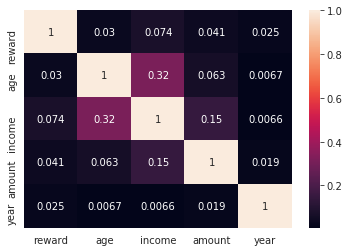

In [83]:
# corelation matrix for numeric type

corrMatrix =  df_offer_type_amount_numeric.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


In [84]:
def create_dummy_df(num_df, cat_df, dummy_na):
    """
    Function to create dummy variables for categorical data

    INPUT:
    num_df - pandas dataframe with numerical variables
    cat_df - pandas dataframe with categorical variables
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not


    OUTPUT:
    num_df - a new dataframe that has the following characteristics:
            1. dummy columns for each of the categorical columns in cat_df
            2. if dummy_na is True - it also contains dummy columns for the NaN values
            3. Use a prefix of the column name with an underscore (_) for separating
    """
            
    cat_df = pd.get_dummies(cat_df, dummy_na=dummy_na)    
    
    num_df = pd.concat([num_df, cat_df], axis=1)

    return num_df

concat_df = create_dummy_df(df_offer_type_amount_numeric, df_offer_type_amount_categoric, dummy_na=False)

In [85]:
concat_df.head()

,reward,age,income,amount,year,offer_type_bogo,offer_type_discount,gender_F,gender_M,gender_O
0,10,75.0,100000.0,21.72,2017.0,1,0,1,0,0
1,10,61.0,57000.0,15.95,2017.0,1,0,1,0,0
2,10,49.0,52000.0,109.30,2014.0,1,0,0,1,0
3,10,64.0,100000.0,31.05,2017.0,1,0,0,1,0
4,10,67.0,96000.0,23.01,2014.0,1,0,0,1,0


In [86]:
def fit_linear_mod(concat_df, test_size=.3, rand_state=42):
    '''
    INPUT:
    concat_df - a dataframe holding all the variables of interest
    test_size - a float between [0,1] about what proportion of data should
                be in the test dataset
    rand_state - an int that is provided as the random state for splitting 
                 the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    
    X = concat_df.drop('amount', axis=1)
    y = concat_df['amount']

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size,
                                                        random_state=rand_state) 

    lm_model = LinearRegression(normalize=True) # Instantiate

    lm_model.fit(X_train, y_train) #Fit

    #Predict and score the model
    y_train_preds = lm_model.predict(X_train) 
    y_test_preds = lm_model.predict(X_test) 

    train_score = r2_score(y_train, y_train_preds)
    test_score = r2_score(y_test, y_test_preds) 
    
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(concat_df)


In [87]:
#Print training and testing score

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".\
      format(train_score, test_score))

The rsquared on the training data was 0.0250641010255.  The rsquared on the test data was 0.0220056104492.


* Build a model that predicts whether or not someone will respond to an offer.

In [88]:
# Prepare data for training the model

""" 
Here we are implementing a Random Forest Classifier to predict whether or not someone will respond to an offer.

To evaluate the trained model we use the f1-score metric. 

The function generate_features_classification generate the features for training and testing.

Here we also implement Grid search to improve the performance Random Forest Classifier by selecting 
the right combination of parameters.   

"""

' \nHere we are implementing a Random Forest Classifier to predict whether or not someone will respond to an offer.\n\nTo evaluate the trained model we use the f1-score metric. \n\nThe function generate_features_classification generate the features for training and testing.\n\nHere we also implement Grid search to improve the performance Random Forest Classifier by selecting \nthe right combination of parameters.   \n\n'

In [89]:
# Copy dataframes

merged_offer_copy = merged_offer.copy()
offer_type_df_copy = offer_type_df.copy()

In [90]:
def generate_features_classification(merged_offer, offer_type_df):
    """
    Function to generate features for training the model

    INPUT:
    merged_offer - (pandas dataframe) merged_offer returned by function offer_viewed_completed
    offer_type_df - (pandas dataframe) offer_type_df returned by function clean_data

    OUTPUT:
    df_concatenated_sorted - (pandas dataframe) df_concatenated_sorted which contains the features
                             for training the model for classification

    """

    # Generate year and month from column became_member_on
    df_merged_became_member_on = pd.to_datetime(merged_offer['became_member_on'], format='%Y%m%d',
                                                errors='ignore').to_frame()
    df_offer_type_became_member_on = pd.to_datetime(offer_type_df['became_member_on'], format='%Y%m%d',
                                                    errors='ignore').to_frame()

    merged_offer['year'] = pd.DatetimeIndex(df_merged_became_member_on['became_member_on']).year
    merged_offer['month'] = pd.DatetimeIndex(df_merged_became_member_on['became_member_on']).month

    offer_type_df['year'] = pd.DatetimeIndex(df_offer_type_became_member_on['became_member_on']).year
    offer_type_df['month'] = pd.DatetimeIndex(df_offer_type_became_member_on['became_member_on']).month

    # Drop column 'event'
    merged_offer.drop(columns=['event'], inplace=True)

    # Find difference of dataframes
    diff_df2 = offer_type_df[~offer_type_df.apply(tuple, 1).isin(merged_offer.apply(tuple, 1))]

    # Filter by 'offer completed'
    df_event_offer_completed = diff_df2[diff_df2['event'] == 'offer completed']

    # Drop column 'event', 'time'
    df_event_offer_completed.drop(columns=['event', 'time'], inplace=True)

    # Drop column 'time'
    merged_offer.drop(columns=['time'], inplace=True)

    # Find difference of dataframes
    diff_df3 = df_event_offer_completed[~df_event_offer_completed.apply(tuple, 1).isin(merged_offer.apply(tuple, 1))]

    # Filter by 'offer completed'
    diff_df2 = diff_df2[diff_df2['event'] != 'offer completed']

    # Dataframes to be concatenated
    merged_offer['respond'] = 'yes'
    diff_df2['respond'] = 'no'
    diff_df3['respond'] = 'no'

    # Drop column 'event', 'time'
    diff_df2.drop(columns=['event', 'time'], inplace=True)

    # Concatenate dataframes
    df_concatenate = pd.concat([merged_offer, diff_df2, diff_df3], ignore_index=True)

    # Remove duplicate rows
    df_concatenate_sorted = df_concatenate.drop_duplicates(
        subset=['reward', 'age', 'became_member_on', 'income', 'offer_type', 'gender', 'person', 'offer id'])

    # Sort dataframes by 'income'
    df_concatenate_sorted = df_concatenate_sorted.sort_values(by=['income'], ascending=False)

    return df_concatenate_sorted
    
df_concatenate_sorted = generate_features_classification(merged_offer_copy, offer_type_df_copy)    

/home/jyothish/.local/lib/python2.7/site-packages/pandas/core/algorithms.py:407: RuntimeWarning: tp_compare didn't return -1 or -2 for exception
  f = lambda x, y: htable.ismember_object(x, values)
/home/jyothish/.local/lib/python2.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [91]:
df_concatenate_sorted.head()

,channels,difficulty,duration,offer id,offer_type,reward,channel_1,channel_2,channel_3,channel_4,age,became_member_on,gender,person,income,year,month,respond
16235,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,email,mobile,social,NaN,84,20160213,F,b624317c94fc496288b746f9be43d170,120000.0,2016,2,yes
8294,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,web,email,mobile,NaN,81,20160825,M,1a8e25a2abe04bc4aa13f91b45c369db,120000.0,2016,8,yes
151984,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,web,email,mobile,NaN,66,20160403,M,5a56cfe9903e420d965a451e84f2bf69,120000.0,2016,4,no
66519,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,54,20160922,F,50c3063af3c04074b817b1488e238e66,120000.0,2016,9,no
71309,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,web,email,mobile,NaN,66,20160403,M,5a56cfe9903e420d965a451e84f2bf69,120000.0,2016,4,no


In [92]:
# numeric cols- difficulty, duration, reward, age, income, respond

df_numeric =  df_concatenate_sorted[['difficulty', 'duration', 'reward', 'age', 'income', 'respond', 'year', 'month']]

# categoric cols - offer_type, gender

df_categoric =  df_concatenate_sorted[['offer_type', 'gender']]

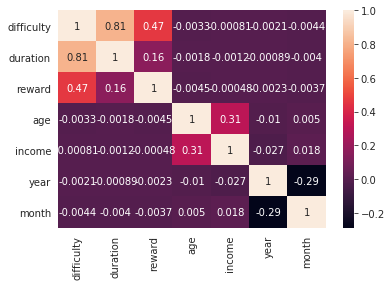

In [93]:
# corelation matrix for numeric type

corrMatrix =  df_numeric.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [94]:
# create and concatinate dummy data

concat_df2 = create_dummy_df(df_numeric, df_categoric, dummy_na=False)

In [95]:
concat_df2.head()

,difficulty,duration,reward,age,income,respond,year,month,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
16235,10,7,10,84,120000.0,yes,2016,2,1,0,0,1,0,0
8294,5,7,5,81,120000.0,yes,2016,8,1,0,0,0,1,0
151984,10,7,2,66,120000.0,no,2016,4,0,1,0,0,1,0
66519,0,4,0,54,120000.0,no,2016,9,0,0,1,1,0,0
71309,0,4,0,66,120000.0,no,2016,4,0,0,1,0,1,0


In [96]:
def build_model_random_forest():
    """
    Function to build the machine learning pipeline

    OUTPUT:
    model - model that is build
    """
    # build machine learning pipeline
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('clf', RandomForestClassifier())
    ])

    parameters = {
        'scaler__feature_range': [(0, 1)],
        'clf__n_estimators': [10, 50, 100],
        'clf__random_state': [50],
        'clf__class_weight': ['balanced'],
        'clf__max_features': ['auto', 'log2', 'sqrt']  
    }

    model_random_forest = GridSearchCV(pipeline, param_grid=parameters)

    return model_random_forest

In [97]:
def build_model_SVC():
    """
    Function to build the machine learning pipeline

    OUTPUT:
    model - model that is build
    """
    # build machine learning pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC())
    ])

    parameters = {
        'scaler__with_mean': [True, False],
        'clf__kernel': ['linear', 'rbf'],
        'clf__C':[1, 10]
    }

    model_SVC = GridSearchCV(pipeline, param_grid=parameters)

    return model_SVC

In [98]:
def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the model

    INPUT:
    model - model to evaluate
    X_test - test feature
    Y_test - test label
    """
    # predict on test data
    Y_pred = model.predict(X_test)
    # display classification report
    print(classification_report(Y_pred, Y_test))
    # display classification accuracy
    accuracy_test = accuracy_score(Y_test, Y_pred)
    print("The model accuracy on test data is: ", accuracy_test)



In [99]:
# Features
X = concat_df2.drop('respond', axis=1)
# Labels
Y = concat_df2['respond']

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print('Building Random Forest Classifier model...')
model_random_forest = build_model_random_forest()

print('Training model...')
model_random_forest.fit(X_train, Y_train)

print('Evaluating model...')
evaluate_model(model_random_forest, X_test, Y_test)


print('Building SVC Classifier model...')
model_SVC = build_model_SVC()

print('Training model...')
model_SVC.fit(X_train, Y_train)

print('Evaluating model...')
evaluate_model(model_SVC, X_test, Y_test)



Building Random Forest Classifier model...
Training model...


/home/jyothish/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jyothish/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Evaluating model...
              precision    recall  f1-score   support

          no       0.78      0.77      0.77      6345
         yes       0.69      0.70      0.70      4700

   micro avg       0.74      0.74      0.74     11045
   macro avg       0.73      0.73      0.73     11045
weighted avg       0.74      0.74      0.74     11045

('The model accuracy on test data is: ', 0.739610683567225)
Building SVC Classifier model...
Training model...


/home/jyothish/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jyothish/.local/lib/python2.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/jyothish/.local/lib/python2.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/jyothish/.local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWa

Evaluating model...


/home/jyothish/.local/lib/python2.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

          no       0.81      0.78      0.80      6484
         yes       0.71      0.74      0.72      4561

   micro avg       0.76      0.76      0.76     11045
   macro avg       0.76      0.76      0.76     11045
weighted avg       0.77      0.76      0.76     11045

('The model accuracy on test data is: ', 0.7639655952919874)


In [100]:
# Best parameters sorted for Random Forest Classifier

pd.DataFrame.from_dict(model_random_forest.cv_results_)

/home/jyothish/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jyothish/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jyothish/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jyothish/.local/lib/python2.7/s

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__class_weight,param_clf__max_features,param_clf__n_estimators,param_clf__random_state,param_scaler__feature_range,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.362952,0.066168,0.731218,0.980793,balanced,auto,10,50,"(0, 1)","{u'clf__max_features': u'auto', u'scaler__feat...",...,0.731427,0.980238,0.729866,0.980442,0.732360,0.981699,0.017803,0.006531,0.001029,0.000646
1,1.459046,0.193342,0.740974,0.997974,balanced,auto,50,50,"(0, 1)","{u'clf__max_features': u'auto', u'scaler__feat...",...,0.741546,0.998065,0.738829,0.997827,0.742547,0.998031,0.023356,0.002561,0.001571,0.000105
2,2.851879,0.359299,0.741268,0.998348,balanced,auto,100,50,"(0, 1)","{u'clf__max_features': u'auto', u'scaler__feat...",...,0.742089,0.998438,0.739644,0.998166,0.742071,0.998438,0.007617,0.004119,0.001148,0.000128
3,0.332325,0.061942,0.731218,0.980793,balanced,log2,10,50,"(0, 1)","{u'clf__max_features': u'log2', u'scaler__feat...",...,0.731427,0.980238,0.729866,0.980442,0.732360,0.981699,0.001939,0.001274,0.001029,0.000646
4,1.443895,0.198648,0.740974,0.997974,balanced,log2,50,50,"(0, 1)","{u'clf__max_features': u'log2', u'scaler__feat...",...,0.741546,0.998065,0.738829,0.997827,0.742547,0.998031,0.013050,0.006700,0.001571,0.000105
5,2.847285,0.359940,0.741268,0.998348,balanced,log2,100,50,"(0, 1)","{u'clf__max_features': u'log2', u'scaler__feat...",...,0.742089,0.998438,0.739644,0.998166,0.742071,0.998438,0.007382,0.003319,0.001148,0.000128
6,0.337208,0.060780,0.731218,0.980793,balanced,sqrt,10,50,"(0, 1)","{u'clf__max_features': u'sqrt', u'scaler__feat...",...,0.731427,0.980238,0.729866,0.980442,0.732360,0.981699,0.002053,0.001131,0.001029,0.000646
7,1.434304,0.190948,0.740974,0.997974,balanced,sqrt,50,50,"(0, 1)","{u'clf__max_features': u'sqrt', u'scaler__feat...",...,0.741546,0.998065,0.738829,0.997827,0.742547,0.998031,0.006087,0.003845,0.001571,0.000105
8,2.829779,0.354670,0.741268,0.998348,balanced,sqrt,100,50,"(0, 1)","{u'clf__max_features': u'sqrt', u'scaler__feat...",...,0.742089,0.998438,0.739644,0.998166,0.742071,0.998438,0.031016,0.002137,0.001148,0.000128


In [101]:
# Best parameters sorted for SVC 

pd.DataFrame.from_dict(model_SVC.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_clf__kernel,param_scaler__with_mean,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,29.785065,4.624806,0.730357,0.730663,1,linear,True,"{u'scaler__with_mean': True, u'clf__C': 1, u'c...",6,0.729458,0.731826,0.730205,0.730434,0.731409,0.729730,0.338496,0.005415,0.000804,0.000871
1,22.521192,3.229491,0.730720,0.730584,1,linear,False,"{u'scaler__with_mean': False, u'clf__C': 1, u'...",5,0.729866,0.731826,0.730748,0.731045,0.731545,0.728881,0.558770,0.022996,0.000686,0.001246
2,35.652666,11.316082,0.756797,0.761697,1,rbf,True,"{u'scaler__with_mean': True, u'clf__C': 1, u'c...",3,0.754244,0.762758,0.757164,0.761706,0.758981,0.760627,0.911756,0.136380,0.001951,0.000870
3,35.115514,11.229277,0.756774,0.761697,1,rbf,False,"{u'scaler__with_mean': False, u'clf__C': 1, u'...",4,0.754176,0.762725,0.757164,0.761672,0.758981,0.760695,0.378033,0.097013,0.001981,0.000829
4,73.144629,4.571095,0.730312,0.730606,10,linear,True,"{u'scaler__with_mean': True, u'clf__C': 10, u'...",8,0.729322,0.731758,0.730273,0.730298,0.731341,0.729764,0.650192,0.041934,0.000825,0.000843
5,22.713673,3.129687,0.730357,0.730855,10,linear,False,"{u'scaler__with_mean': False, u'clf__C': 10, u...",6,0.729254,0.732675,0.729662,0.731113,0.732156,0.728779,0.310816,0.012984,0.001283,0.001601
6,46.918165,11.025688,0.760939,0.767934,10,rbf,True,"{u'scaler__with_mean': True, u'clf__C': 10, u'...",1,0.758726,0.768633,0.760220,0.769482,0.763871,0.765687,2.666337,0.254830,0.002161,0.001626
7,43.782913,10.892715,0.760916,0.767945,10,rbf,False,"{u'scaler__with_mean': False, u'clf__C': 10, u...",2,0.758726,0.768633,0.760220,0.769482,0.763803,0.765720,0.913725,0.220443,0.002130,0.001611
